In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch
from GEH_LOSS import GEH_loss
import geh as ga

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import relative_accuracy as ra

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
# Wide Data
Xtrain = joblib.load("002weeks_train_Multi.save") 
Xtest = joblib.load("002weeks_test_Multi.save") 

In [7]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [8]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [9]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [10]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [11]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [12]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [13]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6                # No of loop detectors
n_seq = 3                     # Subsequences
n_steps = 5                   # time-step per subsequence
# val_percent = 0.07567       # 2 weeks
val_percent = 0.2        
batch_size = 32

n_seq_ = 3                     # Subsequences
n_steps_ = 3                   # time-step per subsequence

#### 5 mins

In [14]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = scaler.inverse_transform(Output_train_5)

In [15]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [16]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = scaler.inverse_transform(Output_train_15)

In [17]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [18]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = scaler.inverse_transform(Output_train_30)

In [19]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [20]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = scaler.inverse_transform(Output_train_60)

In [21]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = scaler.inverse_transform(Output_test_60)

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [22]:
# define no_of_channels
n_channels = 1

In [23]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [24]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

In [25]:
# Train data
Wt5  =  Wt5.reshape(Wt5.shape[0], n_seq_, n_steps_, n_features)
Wt15 =  Wt15.reshape(Wt15.shape[0], n_seq_, n_steps_, n_features)
Wt30 =  Wt30.reshape(Wt30.shape[0], n_seq_, n_steps_, n_features)
Wt60 =  Wt60.reshape(Wt60.shape[0], n_seq_, n_steps_, n_features)

# Validation data
Wv5  =  Wv5.reshape(Wv5.shape[0], n_seq_, n_steps_, n_features)
Wv15 =  Wv15.reshape(Wv15.shape[0], n_seq_, n_steps_, n_features)
Wv30 =  Wv30.reshape(Wv30.shape[0], n_seq_, n_steps_, n_features)
Wv60 =  Wv60.reshape(Wv60.shape[0], n_seq_, n_steps_, n_features)

In [26]:
Xt5.shape

(49233, 3, 5, 6, 1)

In [27]:
Wt5.shape

(49233, 3, 3, 6)

# CNN-LSTM model

In [28]:
from tensorflow import keras
from keras_self_attention import SeqSelfAttention

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)

In [29]:
Wide_train_5.shape

(49233, 9, 6)

# 5 mins ahead

In [30]:
def build_model_5(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt5.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt5.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_5w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_5 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_5w)
    
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_5)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_5, LSTM_5], axis=1)

    # Attention
    Att_5 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_5)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=GEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                                   
    return model_5

In [31]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8e-5",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8e-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8e-5\tuner0.json


In [32]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [33]:
tuner5.search((Wt5,Xt5), yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 60 Complete [00h 10m 07s]
val_loss: 8.43088960647583

Best val_loss So Far: 8.33938455581665
Total elapsed time: 20h 43m 05s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\8e-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 48
filters: 96
kernel_size: 3
learning_rate: 0.001
Score: 8.33938455581665


### Best Model

In [35]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [36]:
scaler_filename = "Best_HP/8e-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/8e-5']

In [37]:
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 3, 4, 96)  960        ['DeepInput[0][0]']              
 buted)                                                                                           
                                                                                            

In [38]:
model5.fit((Wt5,Xt5), yt5, 
           epochs = 100, 
           verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 24s 11ms/step - loss: 11.1671 - mean_absolute_error: 21.8015 - root_mean_squared_error: 37.7937 - mean_absolute_percentage_error: 30.59263s - loss:
Epoch 2/100
1539/1539 [==============================] - 18s 12ms/step - loss: 9.1717 - mean_absolute_error: 15.7536 - root_mean_squared_error: 22.6025 - mean_absolute_percentage_error: 21.6225 1s - loss: 9.1905 - mean_absolute_error: 15.8115 - root_mean_squared_error: 22.6850 - mean_absolute
Epoch 3/100
1539/1539 [==============================] - 18s 12ms/step - loss: 8.7726 - mean_absolute_error: 14.7476 - root_mean_squared_error: 21.0870 - mean_absolute_percentage_error: 19.7174
Epoch 4/100
1539/1539 [==============================] - 17s 11ms/step - loss: 8.6501 - mean_absolute_error: 14.3388 - root_mean_squared_error: 20.4944 - mean_absolute_percentage_error: 18.9200
Epoch 5/100
1539/1539 [==============================] - 18s 12ms/step - loss: 8.5919 - mean_absolute_error: 14.0

1539/1539 [==============================] - 16s 11ms/step - loss: 8.3308 - mean_absolute_error: 13.1216 - root_mean_squared_error: 18.9263 - mean_absolute_percentage_error: 16.5551
Epoch 40/100
1539/1539 [==============================] - 17s 11ms/step - loss: 8.3441 - mean_absolute_error: 13.1186 - root_mean_squared_error: 18.9463 - mean_absolute_percentage_error: 16.5120 ETA: 1s - loss: 8.3541 - mean_absolute_error: 13.1151 - root_mean_squared_error: 18.9423 - mean_absolut
Epoch 41/100
1539/1539 [==============================] - 16s 11ms/step - loss: 8.3348 - mean_absolute_error: 13.1125 - root_mean_squared_error: 18.9328 - mean_absolute_percentage_error: 16.5209
Epoch 42/100
1539/1539 [==============================] - 17s 11ms/step - loss: 8.3215 - mean_absolute_error: 13.0711 - root_mean_squared_error: 18.8757 - mean_absolute_percentage_error: 16.4966
Epoch 43/100
1539/1539 [==============================] - 16s 11ms/step - loss: 8.3121 - mean_absolute_error: 13.0975 - root_mean

In [39]:
model5.save("my_dir/8e-5")

INFO:tensorflow:Assets written to: my_dir/8e-5\assets


INFO:tensorflow:Assets written to: my_dir/8e-5\assets


In [40]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

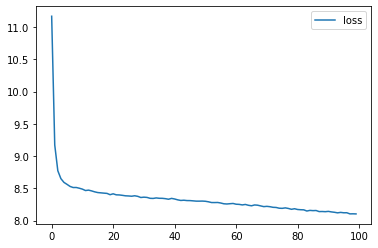

In [41]:
metrics5[['loss']].plot()

In [33]:
model5 = keras.models.load_model("my_dir/8e-5", custom_objects={'GEH_loss': GEH_loss}) 

In [34]:
model5.predict((Wv5,Xv5))

array([[ 32.72192  ,  19.695078 ,  24.172232 ,  74.31604  ,  29.123188 ,
          7.3001795],
       [ 30.147926 ,  15.489574 ,  24.513449 ,  72.64466  ,  28.709612 ,
          6.7407784],
       [ 30.089712 ,  15.704155 ,  21.81952  ,  69.72827  ,  28.151793 ,
          7.3104515],
       ...,
       [ 46.698883 ,  44.822002 ,  63.025814 , 111.12173  ,  50.15107  ,
         13.079116 ],
       [ 44.224052 ,  41.54735  ,  52.86054  , 104.02013  ,  45.810883 ,
         11.633217 ],
       [ 44.16784  ,  41.62521  ,  57.874454 , 107.87239  ,  47.899506 ,
         11.289261 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions5 = model5.predict((Wv5,Xv5))


MSE5 = mean_squared_error(yv5,test_predictions5)

MAE5 = mean_absolute_error(yv5,test_predictions5)

RMSE5 = np.sqrt(MSE5)

MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

eval5 = [MSE5, MAE5, RMSE5, MAPE5]
print(eval5)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))
GEH5 = count/GEH.size
print(GEH5)

# 15 mins ahead

In [37]:
def build_model_15(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt15.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt15.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_15w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_15 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_15w)
    
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_15)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_15, LSTM_15], axis=1)

    # Attention
    Att_15 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_15)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=GEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [38]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8e-15",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8e-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8e-15\tuner0.json


In [39]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [34]:
tuner15.search((Wt15,Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [35]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\8e-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 69
filters: 96
kernel_size: 2
learning_rate: 0.001
Score: 8.610459327697754


### Best model

In [36]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [37]:
scaler_filename = "Best_HP/8e-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/8e-15']

In [38]:
model15.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 96)  480        ['DeepInput[0][0]']              
 buted)                                                                                           
                                                                                            

In [39]:
model15.fit((Wt15,Xt15), yt15, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 44s 15ms/step - loss: 11.0567 - mean_absolute_error: 21.8774 - root_mean_squared_error: 36.8398 - mean_absolute_percentage_error: 31.0616
Epoch 2/100
1539/1539 [==============================] - 22s 15ms/step - loss: 9.2422 - mean_absolute_error: 16.3643 - root_mean_squared_error: 23.4330 - mean_absolute_percentage_error: 22.1179
Epoch 3/100
1539/1539 [==============================] - 24s 16ms/step - loss: 9.0666 - mean_absolute_error: 15.7542 - root_mean_squared_error: 22.6458 - mean_absolute_percentage_error: 20.9335
Epoch 4/100
1539/1539 [==============================] - 22s 15ms/step - loss: 8.9877 - mean_absolute_error: 15.4112 - root_mean_squared_error: 22.1762 - mean_absolute_percentage_error: 20.3942 22s - loss: 9.0475 - mean_absolute_error: 15.1563 - root_mean_squared_error: 22.1067 - mean_absolute_percentage_error: 1 
Epoch 5/100
1539/1539 [==============================] - 22s 14ms/step - loss: 8.9135 - mean_absolute

1539/1539 [==============================] - 23s 15ms/step - loss: 8.4997 - mean_absolute_error: 13.6196 - root_mean_squared_error: 19.7851 - mean_absolute_percentage_error: 17.5074 5s - loss: 8.4908 - mean_absolute_error - ETA: 0s - loss: 8.4988 - mean_absolute_error: 13.6171 - root_mean_squared_error: 19.7882 - mean_absolute_percentage_err
Epoch 58/100
1539/1539 [==============================] - 13s 8ms/step - loss: 8.4892 - mean_absolute_error: 13.6037 - root_mean_squared_error: 19.7557 - mean_absolute_percentage_error: 17.4894
Epoch 59/100
1539/1539 [==============================] - 10s 7ms/step - loss: 8.4772 - mean_absolute_error: 13.5747 - root_mean_squared_error: 19.6999 - mean_absolute_percentage_error: 17.4398
Epoch 60/100
1539/1539 [==============================] - 11s 7ms/step - loss: 8.4751 - mean_absolute_error: 13.5788 - root_mean_squared_error: 19.7019 - mean_absolute_percentage_error: 17.4250
Epoch 61/100
1539/1539 [==============================] - 12s 7ms/step - l

In [40]:
model15.save("my_dir/8e-15")

INFO:tensorflow:Assets written to: my_dir/8e-15\assets


INFO:tensorflow:Assets written to: my_dir/8e-15\assets


In [41]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

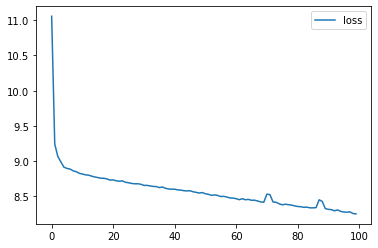

In [42]:
metrics15[['loss']].plot()

In [40]:
model15 = keras.models.load_model("my_dir/8e-15", custom_objects={'GEH_loss': GEH_loss})

In [41]:
model15.predict((Wv15,Xv15))

array([[ 29.312712,  16.555748,  30.564772,  64.36308 ,  26.770935,
          5.632194],
       [ 27.986227,  15.669255,  25.911863,  63.534332,  26.522694,
          5.642757],
       [ 28.778177,  14.98462 ,  28.677515,  66.82657 ,  28.523735,
          6.091917],
       ...,
       [ 46.986347,  46.87968 ,  60.395134, 120.48709 ,  59.323196,
          9.422502],
       [ 45.709133,  43.946823,  64.07001 , 123.481995,  57.61915 ,
          9.276271],
       [ 40.564938,  38.032116,  50.008743, 104.32341 ,  47.990814,
         12.127048]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions15 = model15.predict((Wv15,Xv15))


MSE15 = mean_squared_error(yv15,test_predictions15)

MAE15 = mean_absolute_error(yv15,test_predictions15)

RMSE15 = np.sqrt(MSE15)

MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

eval15 = [MSE15, MAE15, RMSE15, MAPE15]
print(eval15)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))
GEH15 = count/GEH.size
print(GEH15)

# 30 mins ahead

In [44]:
def build_model_30(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt30.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt30.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_30w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_30 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_30w)
    
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_30)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_30, LSTM_30], axis=1)

    # Attention
    Att_30 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_30)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=GEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [45]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8e-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8e-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8e-30\tuner0.json


In [46]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [46]:
tuner30.search((Wt30,Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 61 Complete [00h 19m 27s]
val_loss: 8.891591548919678

Best val_loss So Far: 8.739480972290039
Total elapsed time: 11h 25m 43s
INFO:tensorflow:Oracle triggered exit


In [47]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\8e-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 54
filters: 32
kernel_size: 3
learning_rate: 0.001
Score: 8.739480972290039


### Best model

In [48]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [49]:
scaler_filename = "8e-30"
joblib.dump(best_hp30, scaler_filename) 

['8e-30']

In [50]:
model30.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 3, 4, 32)  320        ['DeepInput[0][0]']              
 buted)                                                                                           
                                                                                            

In [51]:
model30.fit((Wt30,Xt30), yt30, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 18s 7ms/step - loss: 12.0206 - mean_absolute_error: 25.0468 - root_mean_squared_error: 41.9461 - mean_absolute_percentage_error: 35.7960
Epoch 2/100
1539/1539 [==============================] - 11s 7ms/step - loss: 9.9999 - mean_absolute_error: 18.2725 - root_mean_squared_error: 26.6229 - mean_absolute_percentage_error: 25.3745
Epoch 3/100
1539/1539 [==============================] - 11s 7ms/step - loss: 9.7748 - mean_absolute_error: 17.6896 - root_mean_squared_error: 25.6609 - mean_absolute_percentage_error: 24.0223
Epoch 4/100
1539/1539 [==============================] - 11s 7ms/step - loss: 9.3938 - mean_absolute_error: 16.8638 - root_mean_squared_error: 24.2707 - mean_absolute_percentage_error: 22.4744
Epoch 5/100
1539/1539 [==============================] - 11s 7ms/step - loss: 9.3094 - mean_absolute_error: 16.5541 - root_mean_squared_error: 23.8761 - mean_absolute_percentage_error: 21.8857: 4s - loss: 9.3456 - mean_absolute

1539/1539 [==============================] - 12s 8ms/step - loss: 8.7096 - mean_absolute_error: 14.2672 - root_mean_squared_error: 20.7721 - mean_absolute_percentage_error: 18.4879
Epoch 79/100
1539/1539 [==============================] - 12s 8ms/step - loss: 8.7037 - mean_absolute_error: 14.2474 - root_mean_squared_error: 20.7363 - mean_absolute_percentage_error: 18.4306
Epoch 80/100
1539/1539 [==============================] - 12s 8ms/step - loss: 8.7002 - mean_absolute_error: 14.1999 - root_mean_squared_error: 20.6759 - mean_absolute_percentage_error: 18.4106
Epoch 81/100
1539/1539 [==============================] - 12s 8ms/step - loss: 8.6940 - mean_absolute_error: 14.2269 - root_mean_squared_error: 20.6977 - mean_absolute_percentage_error: 18.4026
Epoch 82/100
1539/1539 [==============================] - 12s 8ms/step - loss: 8.6963 - mean_absolute_error: 14.1977 - root_mean_squared_error: 20.6692 - mean_absolute_percentage_error: 18.3926: 3s - loss: 8.6920 - mean_absolute_error: 1

In [52]:
model30.save("my_dir/8e-30")

INFO:tensorflow:Assets written to: my_dir/8e-30\assets


INFO:tensorflow:Assets written to: my_dir/8e-30\assets


In [53]:
metrics30 = pd.DataFrame(model30.history.history)

<AxesSubplot:>

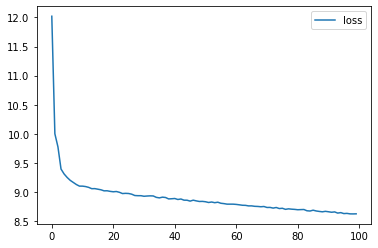

In [54]:
metrics30[['loss']].plot()

In [47]:
model30 = keras.models.load_model("my_dir/8e-30", custom_objects={'GEH_loss': GEH_loss})

In [48]:
model30.predict((Wv30,Xv30))

array([[ 27.874651,  15.93208 ,  27.715094,  59.89956 ,  30.16772 ,
          5.882543],
       [ 26.183598,  15.502625,  11.872586,  55.278656,  26.998692,
          5.989689],
       [ 27.360043,  15.156365,  17.884285,  56.95162 ,  28.246216,
          5.784392],
       ...,
       [ 44.34523 ,  42.110157,  57.0943  , 113.95286 ,  52.086235,
          7.969345],
       [ 41.7756  ,  39.493217,  52.711895, 104.85813 ,  47.547943,
          9.400253],
       [ 40.581127,  36.38985 ,  51.056377, 100.845116,  46.50183 ,
          7.906383]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions30 = model30.predict((Wv30,Xv30))


MSE30 = mean_squared_error(yv30,test_predictions30)

MAE30 = mean_absolute_error(yv30,test_predictions30)

RMSE30 = np.sqrt(MSE30)

MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

eval30 = [MSE30, MAE30, RMSE30, MAPE30]
print(eval30)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))
GEH30 = count/GEH.size
print(GEH30)

# 60 mins ahead

In [51]:
def build_model_60(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt60.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt60.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_60w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_60 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_60w)
    
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_60)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_60, LSTM_60], axis=1)

    # Attention
    Att_60 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_60)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=GEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [52]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8e-60",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8e-60\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8e-60\tuner0.json


In [53]:
tuner60.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [54]:
tuner60.search((Wt60,Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 61 Complete [00h 21m 28s]
val_loss: 9.262146472930908

Best val_loss So Far: 8.986808776855469
Total elapsed time: 16h 21m 51s
INFO:tensorflow:Oracle triggered exit


In [55]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\8e-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 21
filters: 224
kernel_size: 2
learning_rate: 0.001
Score: 8.986808776855469


### Best model

In [56]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [57]:
scaler_filename = "Best_HP/8e-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/8e-60']

In [58]:
model60.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 224  1120       ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [59]:
model60.fit((Wt60,Xt60), yt60, 
            epochs = 100, 
            verbose = 1
            )

Epoch 1/100
1539/1539 [==============================] - 38s 19ms/step - loss: 12.2731 - mean_absolute_error: 26.3861 - root_mean_squared_error: 43.2724 - mean_absolute_percentage_error: 37.4054: 11s - loss: 13.3858 - mean_absolute_error: 29.9112 - root_mean_sq - ETA: 4s - loss: 12.5823 - mean_absolute_error: 27.3665 - root_mean_squared_ - ETA: 2s - loss: 12.4515 - mean_absolute_err
Epoch 2/100
1539/1539 [==============================] - 29s 19ms/step - loss: 10.5294 - mean_absolute_error: 20.7516 - root_mean_squared_error: 30.0068 - mean_absolute_percentage_error: 28.02591s - loss: 10.5286 - mean_absolute_error: 20.8033 - root_mean_square
Epoch 3/100
1539/1539 [==============================] - 30s 19ms/step - loss: 10.2767 - mean_absolute_error: 19.7687 - root_mean_squared_error: 28.5412 - mean_absolute_percentage_error: 26.51505s - loss: 10.2913 - mean_absolute_error: 19.8273 - root_mean_squared_error: 2 - ETA
Epoch 4/100
1539/1539 [==============================] - 30s 19ms/step -

1539/1539 [==============================] - 24s 15ms/step - loss: 9.2181 - mean_absolute_error: 15.9025 - root_mean_squared_error: 23.2399 - mean_absolute_percentage_error: 20.5618 6s - loss: 9.2105 - mean_absolute_error: 15.8706 - root_mean_squared_error: 23.2124 - mean_absolute_percentage_error: 20.78 - ETA: 6s - loss: 9.2126 - mean_absolute_error: 15.8742 - root_mean_squared_error: 23.2213 - mean_absolute_per - ETA: 5s - loss: 9.2134 - me
Epoch 55/100
1539/1539 [==============================] - 25s 16ms/step - loss: 9.2235 - mean_absolute_error: 15.8860 - root_mean_squared_error: 23.2174 - mean_absolute_percentage_error: 20.5862
Epoch 56/100
1539/1539 [==============================] - 26s 17ms/step - loss: 9.2201 - mean_absolute_error: 15.8623 - root_mean_squared_error: 23.1827 - mean_absolute_percentage_error: 20.5238
Epoch 57/100
1539/1539 [==============================] - 26s 17ms/step - loss: 9.2010 - mean_absolute_error: 15.8594 - root_mean_squared_error: 23.1866 - mean_abs

In [60]:
model60.save("my_dir/8e-60")

INFO:tensorflow:Assets written to: my_dir/8e-60\assets


INFO:tensorflow:Assets written to: my_dir/8e-60\assets


In [61]:
metrics60 = pd.DataFrame(model60.history.history)

<AxesSubplot:>

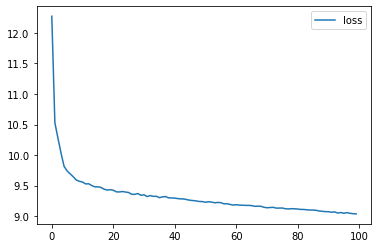

In [62]:
metrics60[['loss']].plot()

In [63]:
model60 = keras.models.load_model("my_dir/8e-60", custom_objects={'GEH_loss': GEH_loss})

In [64]:
model60.predict((Wv60,Xv60))

array([[ 29.469704 ,  15.134949 ,  14.936466 ,  60.36817  ,  28.699556 ,
          5.125877 ],
       [ 28.145576 ,  13.994084 ,  11.576061 ,  59.192444 ,  29.458315 ,
          6.2517905],
       [ 29.144009 ,  15.20198  ,  11.734049 ,  58.987686 ,  29.95547  ,
          6.751257 ],
       ...,
       [ 40.84218  ,  38.637497 ,  58.235634 , 123.174416 ,  49.907284 ,
         14.900343 ],
       [ 41.59125  ,  40.554317 ,  61.68642  , 123.30201  ,  49.357353 ,
         11.969831 ],
       [ 38.46529  ,  35.95047  ,  50.54866  , 115.38683  ,  50.555702 ,
         11.633176 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions60 = model60.predict((Wv60,Xv60))


MSE60 = mean_squared_error(yv60,test_predictions60)

MAE60 = mean_absolute_error(yv60,test_predictions60)

RMSE60 = np.sqrt(MSE60)

MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

eval60 = [MSE60, MAE60, RMSE60, MAPE60]
print(eval60)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))
GEH60 = count/GEH.size
print(GEH60)